# Relion comparison

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
plt.rcParams["figure.figsize"]=10,10

from src.utils import volume_fourier, mip_x, mip_z, create_2d_mask, create_3d_mask
from src.projection import project, project_star_params
#from src.interpolate import *

from external.pyem.pyem import star
import mrcfile

### The volume

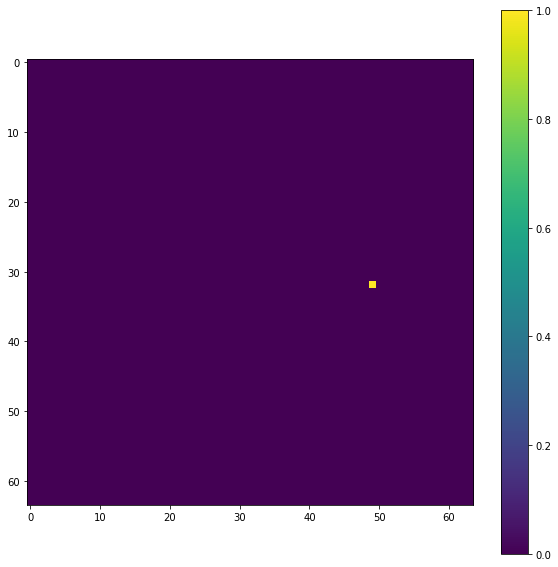

In [3]:
nx = 64
dx = 0.2

vol = np.zeros([nx,nx,nx])
vol[32,49,32] = 1

vol_relion = np.zeros([nx,nx,nx])
vol_relion[32,32,49] = 1

mip_x(vol_relion); plt.colorbar()


### Relion projection

Write the volume to file so it can be processed by Relion

In [4]:
#with mrcfile.new('../data/pointmass.mrc', overwrite=True) as mrc:
#    mrc.set_data(vol_relion.astype(np.float32))

Then start the Relion Singularity instance on a job on the cluster, go to the data directory and run on of the following:

```~/project/relion/build/bin/relion_project --i pointmass.mrc --o relion_proj.mrc --ctf false```

```~/project/relion/build/bin/relion_project --i pointmass.mrc --o relion_proj_rot45tilt_shifts.mrc --pad 1 --angpix 1 --rot 45 --tilt 22.5 --xoff 10 --yoff 55```

```~/project/relion/build/bin/relion_project --i pointmass.mrc --o relion_proj_star  --ang pyem_onerow.star  --pad 1 --ctf true```




Then load the result:

In [26]:
with mrcfile.open('../data/relion_proj_star.mrcs') as mrc:
    proj_relion = mrc.data

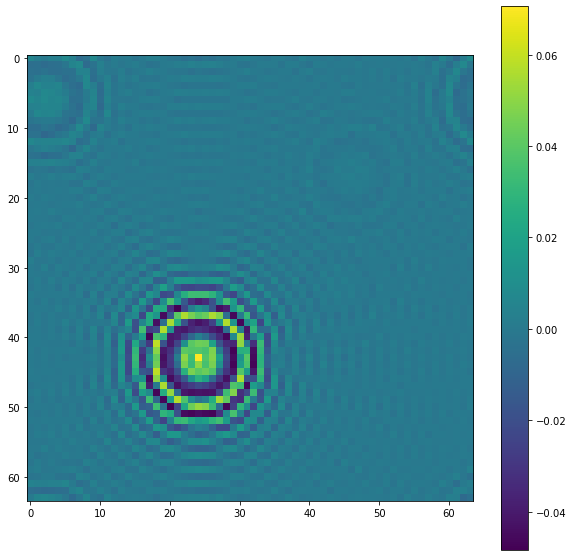

In [27]:
plt.imshow(proj_relion); plt.colorbar()

### My projection

In [28]:
df = star.parse_star("../data/pyem_onerow.star", keep_index = False)
dfiter = df.iterrows()
i, p = next(dfiter)

Parameters from the star file

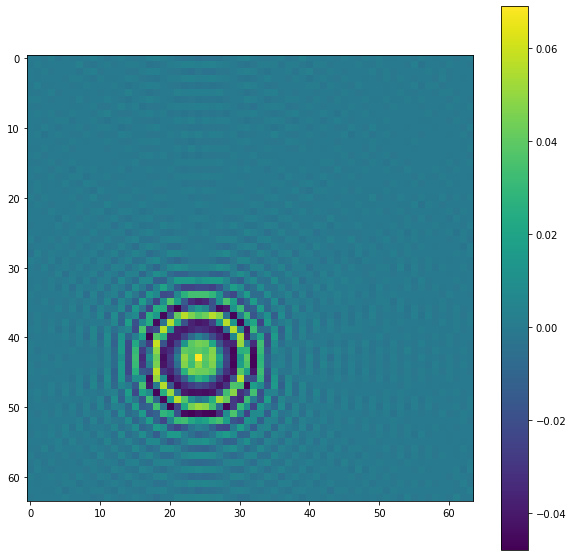

In [29]:
proj = project_star_params(vol, p, pfac = 1)
plt.imshow(proj); plt.colorbar()

### Compare

In [30]:
f2d = np.fft.fftshift(np.fft.fftn(proj))
f2d_relion = np.fft.fftshift(np.fft.fftn(proj_relion))

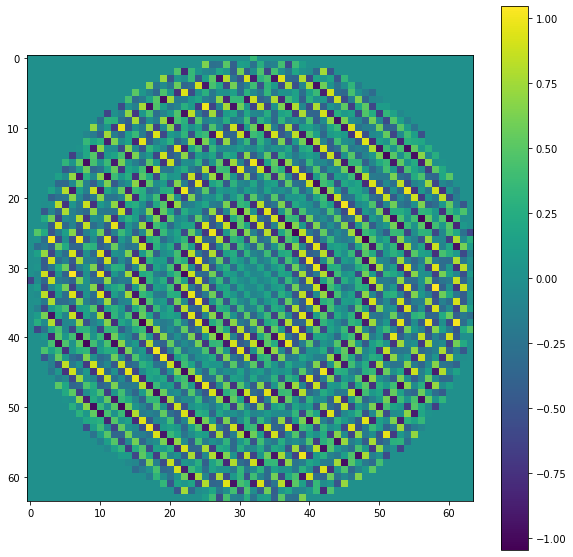

In [31]:
plt.imshow(np.real(f2d)); plt.colorbar()

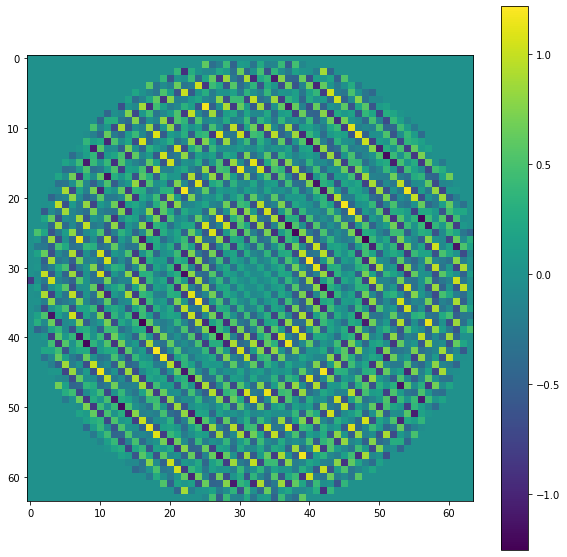

In [32]:
plt.imshow(np.real(f2d_relion)); plt.colorbar()

0.489052264435981

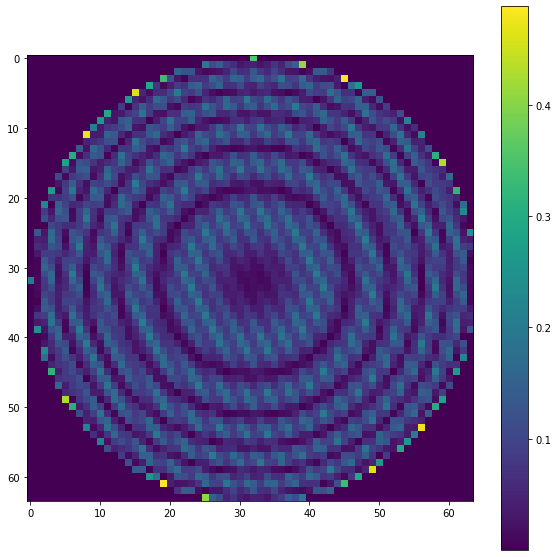

In [33]:
diff = f2d - f2d_relion
plt.imshow(np.abs(diff)); plt.colorbar()
np.max(np.abs(diff))

0.35578826673089314

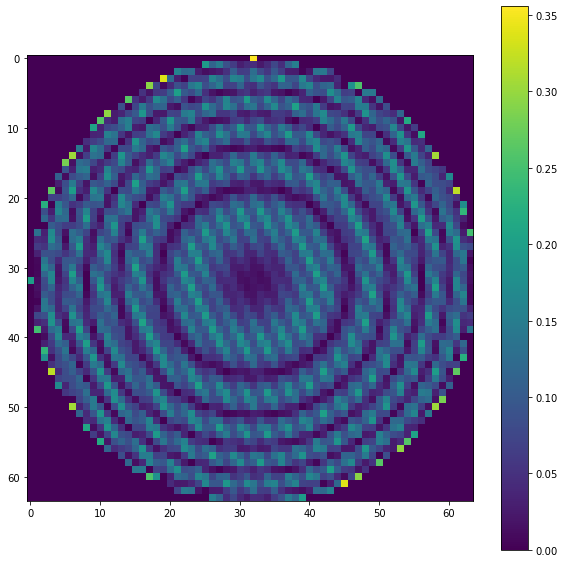

In [34]:
diff[np.abs(diff) > 0.4] = 0
plt.imshow(np.abs(diff)); plt.colorbar()
np.max(np.abs(diff))

### Batch comparison

Run relion on multiple orientations etc:

```~/project/relion/build/bin/relion_project --i pointmass.mrc --o relion_proj_batch  --ang ../external/pyem/pyem.star  --pad 1 --ctf true```

Then load the file:

In [14]:
with mrcfile.open('../data/relion_proj_batch.mrcs') as mrc:
    proj_relion = mrc.data

In [15]:
df = star.parse_star("../external/pyem/pyem.star", keep_index = False)
dfiter = df.iterrows()
#i, p = next(dfiter)

In [16]:
proj = np.array([project_star_params(vol, p, pfac = 1) for (i,p) in dfiter])

In [17]:
f2d = np.array([np.fft.fftshift(np.fft.fftn(p)) for p in proj])
f2d_relion = np.array([np.fft.fftshift(np.fft.fftn(p)) for p in proj_relion])

In [18]:
diff = f2d - f2d_relion
np.sum(np.abs(diff) > 0.001)

27

In [19]:
diff[np.abs(diff) > 0.001] = 0
np.max(np.abs(diff))

6.328747320649697e-08

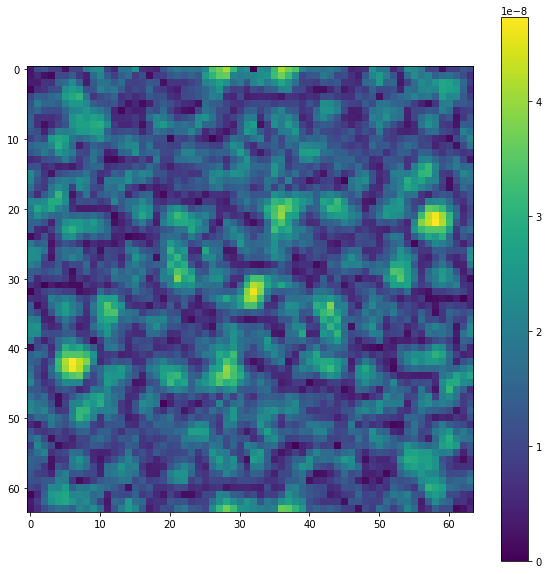

In [20]:
plt.imshow(np.abs(diff[5])); plt.colorbar()